In [43]:
import pandas as pd
import sympy as sy
import matplotlib.pyplot as plt
import numpy as np
import incerts as inc
from scipy.optimize import curve_fit

In [6]:
#   Defining symbols
x, y = sy.symbols('x y')

In [35]:
#   Defining global constants
E  = 8.85
r = 8.56e-3 / 2
sr = 0.01e-3
A = np.pi * r**2
sA = np.pi * inc.incerts(x**2, [x], [r], [sr])
d = 1.86e-3
sd = 0.01e-3

C0 = E * A / d
sC0 =  E * inc.incerts(x/y, [x, y], [A, d], [sA, sd])

Text(0, 0.5, 'C / pF')

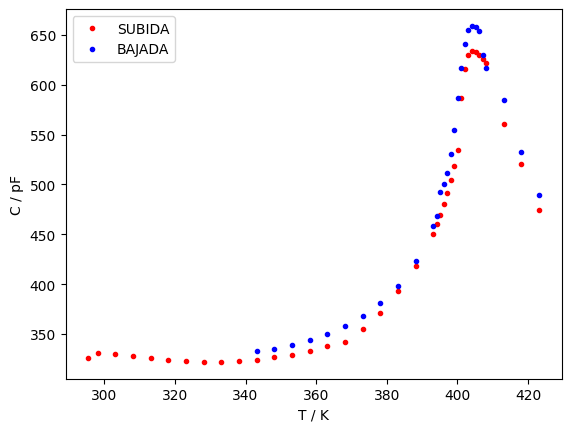

In [52]:
#   Load data
data = pd.read_csv('FES_Curie.csv')

#   Plot C - T

ax = plt.gca()

data['T'] = data['T'].astype(float) + 273.15
data['SUBIDA'] = data['SUBIDA'].astype(float)
data['BAJADA'] = data['BAJADA'].astype(float)
sub = data.plot(x = 'T', y = 'SUBIDA', ax = ax, style = 'r.')
baj = data.plot(x = 'T', y = 'BAJADA', ax = ax, style = 'b.')
ax.set_xlabel('T / K')
ax.set_ylabel('C / pF')

In [47]:
#   Define C-W function for fit
def cw(T, C, Tc):
    return 1 + C / (T - Tc)

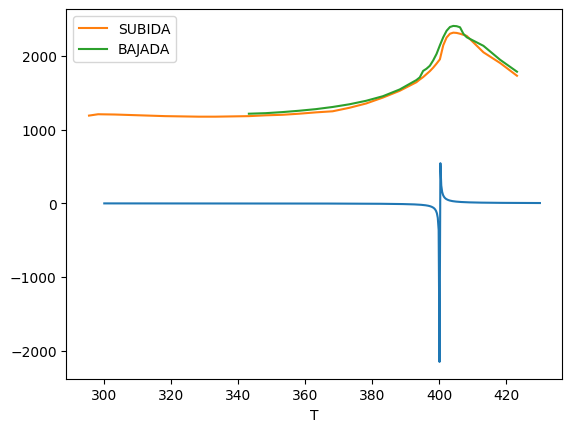

In [51]:
#   Plot \epsilon - T and fitting through C-W
data = pd.read_csv('FES_Curie.csv')
ax = plt.gca()

data['T'] = data['T'].astype(float) + 273.15
data['SUBIDA'] = data['SUBIDA'].astype(float) / C0
data['BAJADA'] = data['BAJADA'].astype(float) / C0

fit_S, cov_S = curve_fit(cw, data['T'], data['SUBIDA'], p0 = [10**5, 400])

xdata_S = np.linspace(300, 430, 500)
ydata_S = cw(xdata_S, fit_S[0], fit_S[1])
ax.plot(xdata_S, ydata_S)
sub = data.plot(x = 'T', y = 'SUBIDA', ax = ax)
baj = data.plot(x = 'T', y = 'BAJADA', ax = ax)

